# Backpropagation
VideoLink: https://spiraldatagroup.atlassian.net/browse/TDPIMP-80
Backpropagation is a method for calculating the gradients by using the chain rule based on a loss function.
This notebook provides a simple example of backpropagation in a neural network.
Backpropogation 

The `_backward` is the most complex concept that is being discussed at around 01:16:00 of the lecture

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

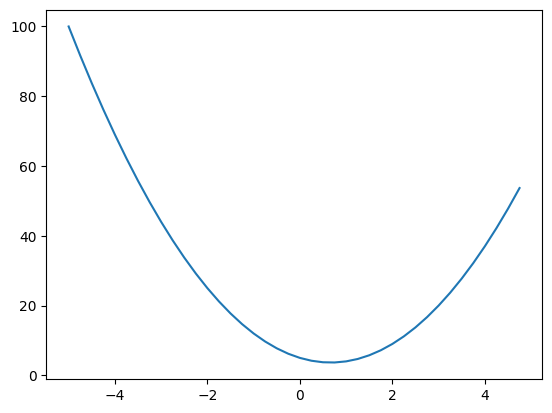

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

You cannot use symbolic expressions of derivatives in neural networks as there are millions to billions of likely parameters
further reducing h value will lead to floating point errors and a 0 value

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [8]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a+=h  # The derivative w.r.t a is value of b
# b += h # The derivative w.r.t b is value of a
c += h # The derivative w.r.t c is 1
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
# Test code for Value Class. Building it up slowly
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # _children is a tuple of values with default being an empty tuple
        self.data = data
        self.grad = 0.0
        self._backward = (
            lambda: None
        )  # By default, the backward function does nothing, for example on the leaf nodes 
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    # DONT GET: Why do we need to pass (self, other) to the __add__ method?
    def __add__(self, other):
        # The passing of (self, other) as child is key to be able to invoke the _backward() function and work as expected
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # If you dont use += and just =, it will overwrite the gradient if self is same as other
            self.grad += out.grad * 1.0  # dL/dx = dL/dy * dy/dx and dy/dx = 1
            other.grad += out.grad * 1.0

        out._backward = _backward
        return out

    def __mul__(self, other):
        # The passing of (self, other) as child is key to be able to invoke the _backward() function and work as expected
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2) # d/dx tanh(x) = 1 - tanh(x)**2
        out._backward = _backward
        return out
    
    def backward(self):
        topo_lst = []
        visited = set()
        # build_topo is a recursive function to recurse through the children
        # until you hit the starting node
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_lst.append(v)
        build_topo(self)
        print(f"topo list before reversed: {topo_lst}")
        topo_lst = reversed(topo_lst)
        print(f"topo list after reversed: {topo_lst}")
        self.grad = 1.0
        for node in topo_lst:
            node._backward()



    

In [11]:
a = Value(2.0, label="a")
print(a)
b = Value(-3.0, label="b")
print(b)
c =Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f =Value(-2.0, label="f")
L = d * f
L.label = "L"

print(L)

Value(data=2.0)
Value(data=-3.0)
Value(data=-8.0)


We need to backpropogate to calculate the derivative of all the nodes wrt the loss function L. In real world scenario, these derivatives will be wrt wieghts of the nodes which we are optimising for.
We wont calculate the derivatives of the input values (leaf nodes) wrt the loss function.

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


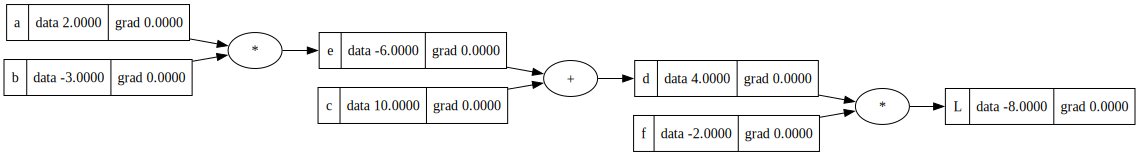

In [13]:
draw_dot(L)

Impact of changing c on the loss function L
$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \frac{\partial d}{\partial c}
$$
However the little `+` node coneecting d and c only knows the local information and does not know about the massive network (or graph) within which it is embedded.
All the information it needs is the gradient value at the node it is connected to (d). This is why we need to store local gradients at each node, so calculating the new gradient is just calculating the local gradient at the node and multiplying it by the gradient value at the node it is connected to.

In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-8.0


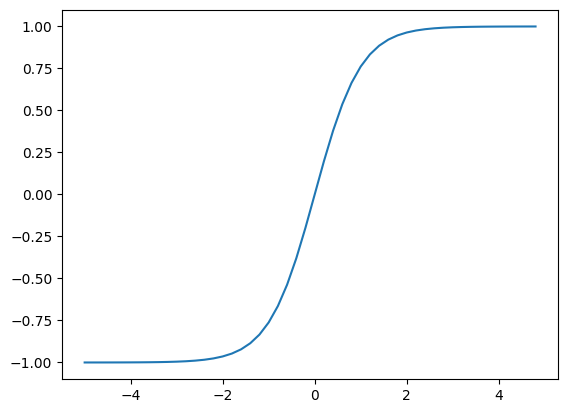

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))

The value that you are most interested in is the gradient of the loss function wrt the weights of the network. (w1 and w2)

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# When you call this expression, the _backward method is now not None anymore. It  is set to the function as described in the tanh() method, which is the gradient of the tanh function, which can be e
o = n.tanh(); o.label = 'o'

In [26]:
o.grad = 1.0
# o._backward()
# n._backward()

In [31]:
# WARNING: Multiple invocations will add the gradient to all child nodes
o.backward()

topo list before reversed: [Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]
topo list after reversed: <list_reverseiterator object at 0x1084f7bb0>


In [19]:
n._backward()

In [23]:
# x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

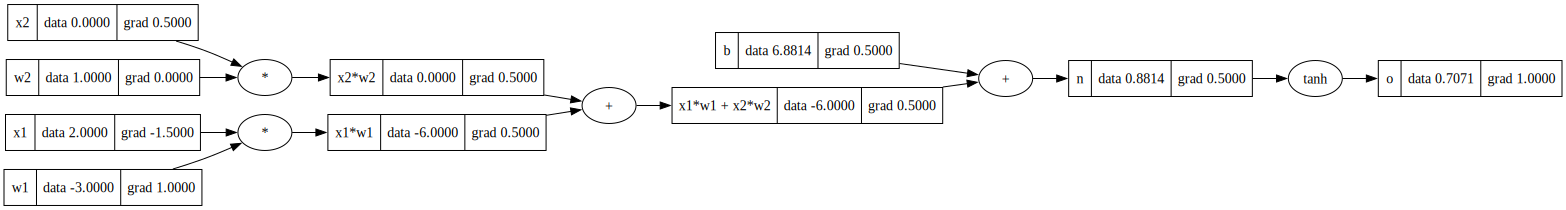

In [32]:
draw_dot(o)

topo list before reversed: [Value(data=3.0), Value(data=6.0)]
topo list after reversed: <list_reverseiterator object at 0x108591210>


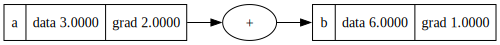

In [33]:
# Edge case where current implementation will FAIL
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

topo list before reversed: [Value(data=-2.0), Value(data=3.0), Value(data=1.0), Value(data=-6.0), Value(data=-6.0)]
topo list after reversed: <list_reverseiterator object at 0x10852d510>


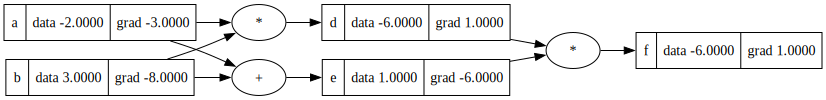

In [34]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)